# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#use this cell to import additional libraries or define helper functions
from sklearn import linear_model

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [3]:
#Load your data into a pandas dataframe here
df = pd.read_csv('household_power_clean.csv')

In [4]:
#convert datetime to epoch/unix time
df['Datetime'] = pd.to_datetime(df['Datetime']).astype(str)
df['unix'] = (pd.to_datetime(df['Datetime']) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly,unix
0,0,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,NaN,NaN,NaN,NaN,1166289840
1,1,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,NaN,NaN,NaN,NaN,1166289900
2,2,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,NaN,NaN,NaN,NaN,1166289960
3,3,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,2006-12-16 17:27:00,NaN,NaN,NaN,NaN,1166290020
4,4,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,2006-12-16 17:28:00,NaN,NaN,NaN,NaN,1166290080


## Predicting Global Active Power

We will follow the code from the Chapter 10 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: ph is the abbreviation for the prediction horizon, which represents the number of time steps into the future that the code will attempt to predict the power consumption values. In this code, ph is set to 5, which means that the code will try to predict the power consumption values 5 minutes into the future.

mu is the forgetting factor, It exponentially decays the data from the history which is a forecasting method used to make predictions based on past values in a time series. In this code, mu is set to 0.9, which means that more weight is given to recent data and less weight is given to older data when making predictions. The value of mu typically ranges between 0 and 1, and the closer it is to 1, the more weight is given to recent data.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [5]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = int(ph / (ts.iloc[1,0] - ts.iloc[0,0])) #ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: With mu = 0.9, the weight of the first data point on the last (5000th) prediction in our limited dataset would be 0.9^4999, which is approximately equal to 1.084e-54. This weight is very small, which means that the influence of the first data point on the last prediction is negligible. This is because mu controls the rate at which the influence of past data diminishes as we move forward in time. A value of mu = 0.9 means that the influence of data from 100 time steps ago is only 1/10th as strong as the influence of the current data. Therefore, the influence of data from 5000 time steps ago (i.e., the first data point in our limited dataset) is extremely small.

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [6]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
        
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k 
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp =  LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

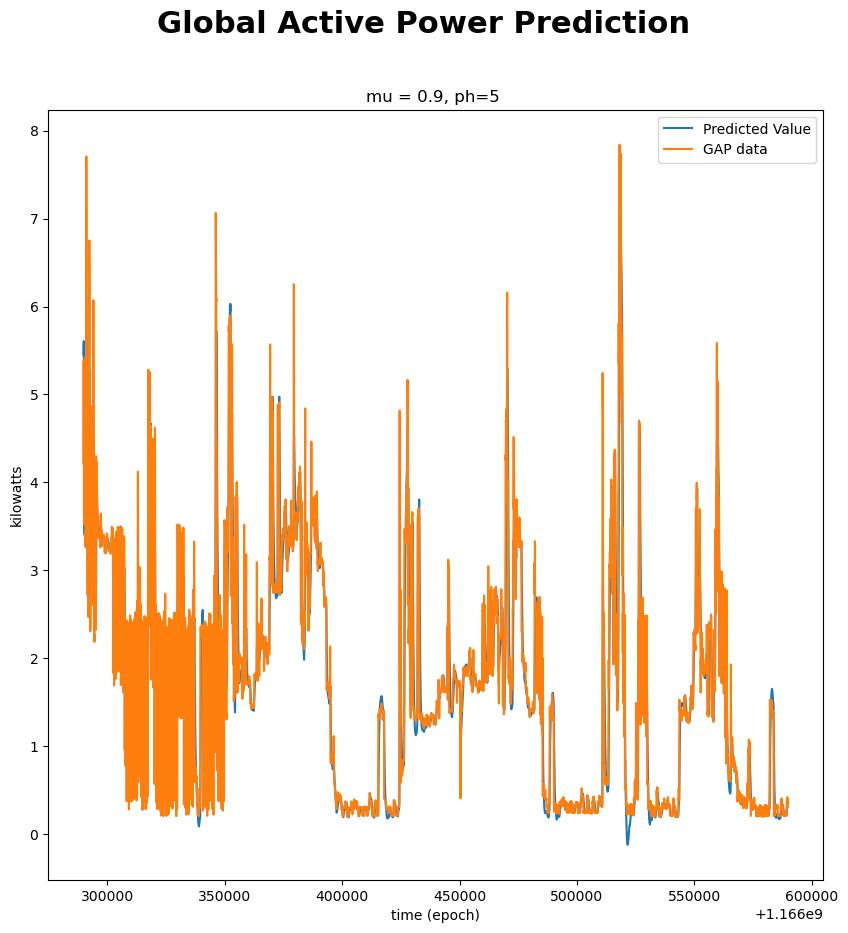

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

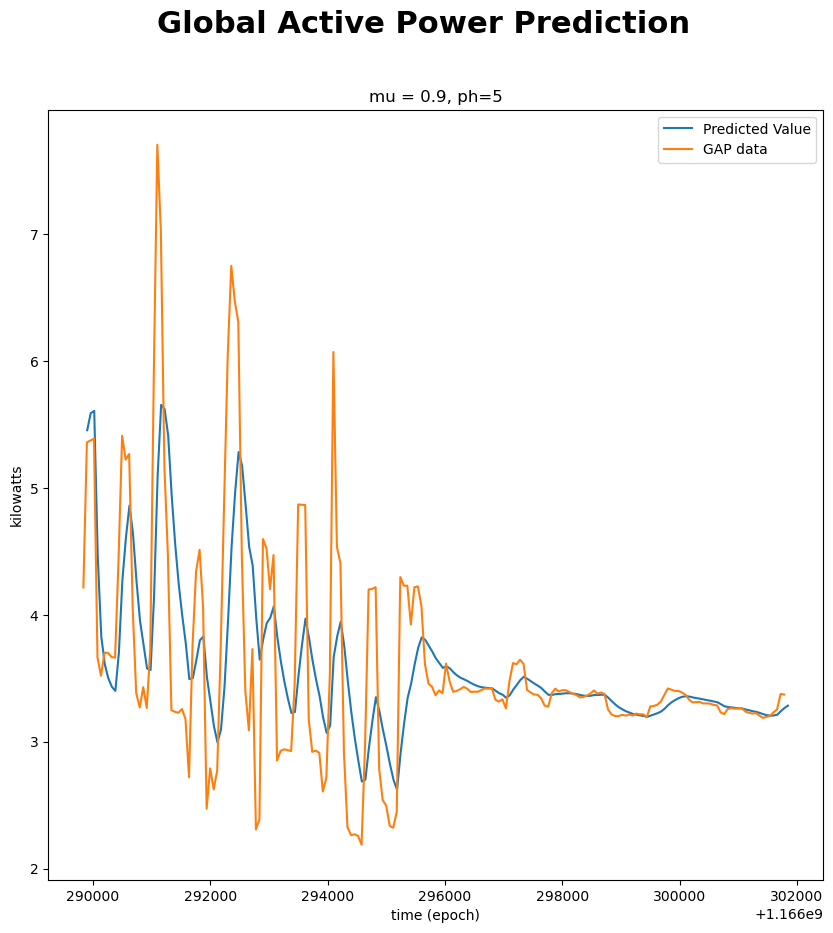

In [8]:
#Plot first 200 data points/predictions
t_tot = [l for l in range(int (min(tp_pred)), int(min(tp_pred+3000)))]
fig, ax = plt.subplots (figsize= (10,10))
fig. suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)') 
ax.set_ylabel('kilowatts')
ax.legend()

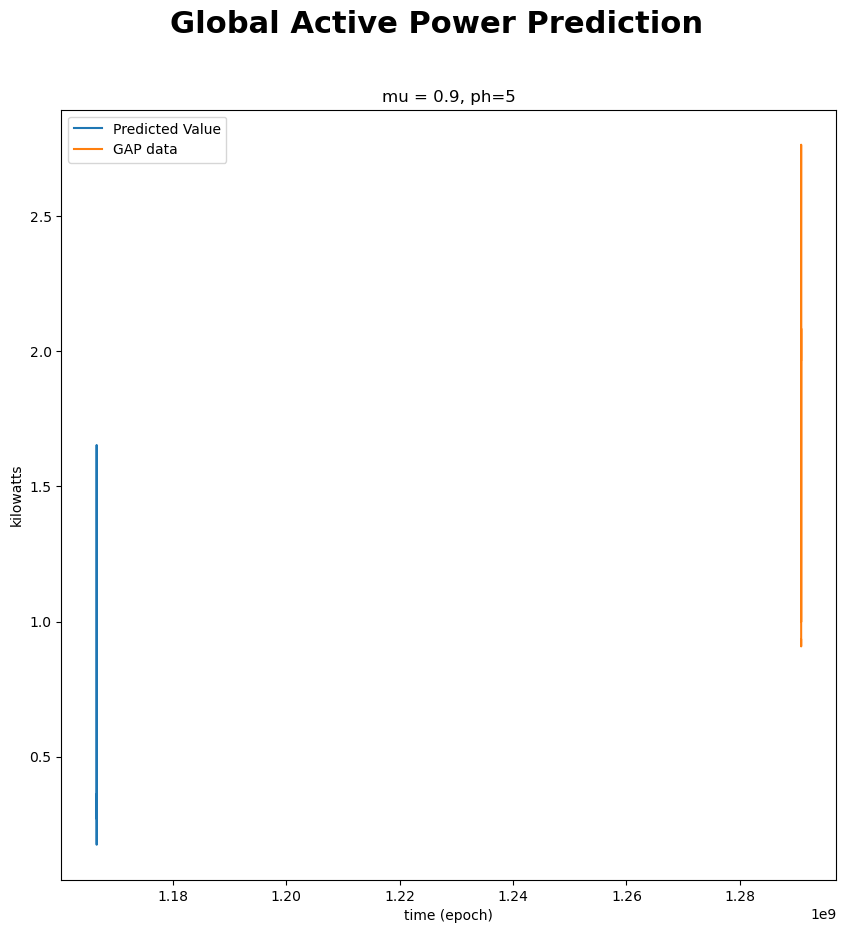

In [9]:
#Plot last 200 data points/predictions

fig, ax = plt.subplots (figsize= (10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
#n = len(tp_pred)
#ax.plot(tp_pred[n-200:n], yp_pred[n-200:n], label='Predicted Value')
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')

ax.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data')
ax.set_xlabel('time (epoch)') 
ax.set_ylabel('kilowatts')
ax.legend()


In [10]:
from sklearn.metrics import mean_squared_error as mse
#Calculate MSE of predictions
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.17650896514059616


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: Our model's performance can be evaluated based on the mean squared error (MSE) value, which is 0.1756. A lower MSE indicates better performance, so our model is not very accurate. The plot shows that our model generally follows the trend of the real data, but has difficulty in identifying variability, resulting in less accurate predictions. The errors in the last 200 predictions are slightly larger than those in the initial predictions. Overall, while our model shows some promise, there is definitely room for improvement.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

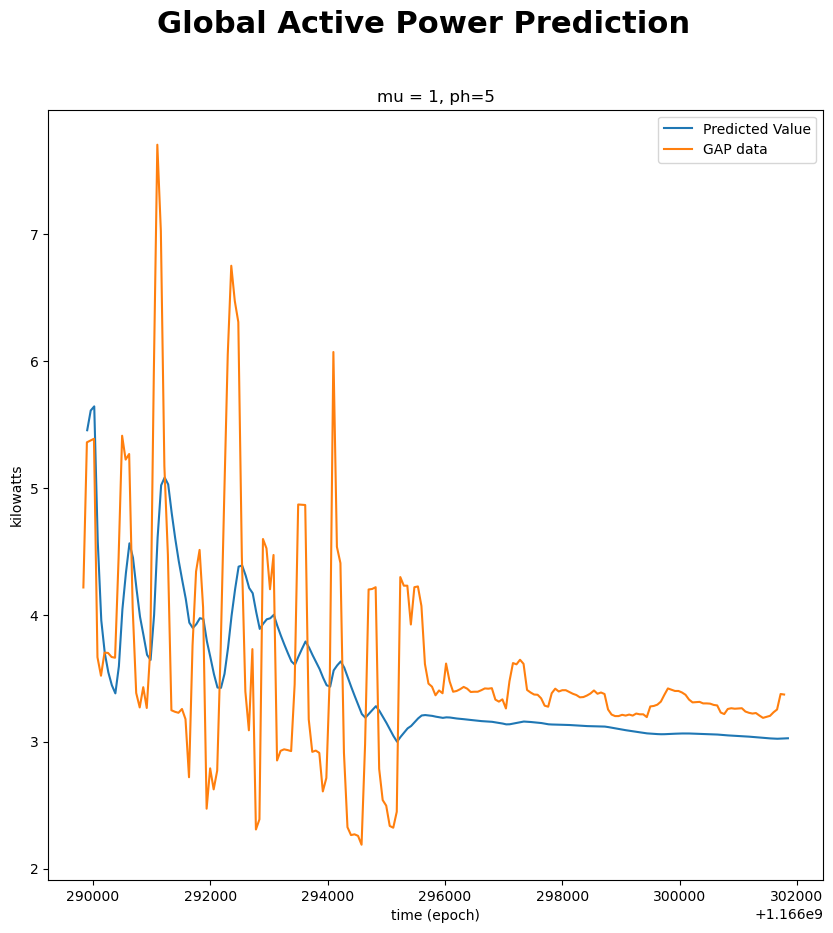

In [11]:
#Plot first 200 data points/predictions for mu = 1

ph = 5 #5 minutes
ph_index = int(ph / (ts.iloc[1,0] - ts.iloc[0,0])) #ph/data resolution (how many timesteps is our ph?)
mu = 1

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
        
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k 
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp =  LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp
    
#Plot first 200 data points/predictions

t_tot = [l for l in range(int (min(tp_pred)), int(min(tp_pred+3000)))]
fig, ax = plt.subplots (figsize= (10,10))
fig. suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)') 
ax.set_ylabel('kilowatts')
ax.legend()
    

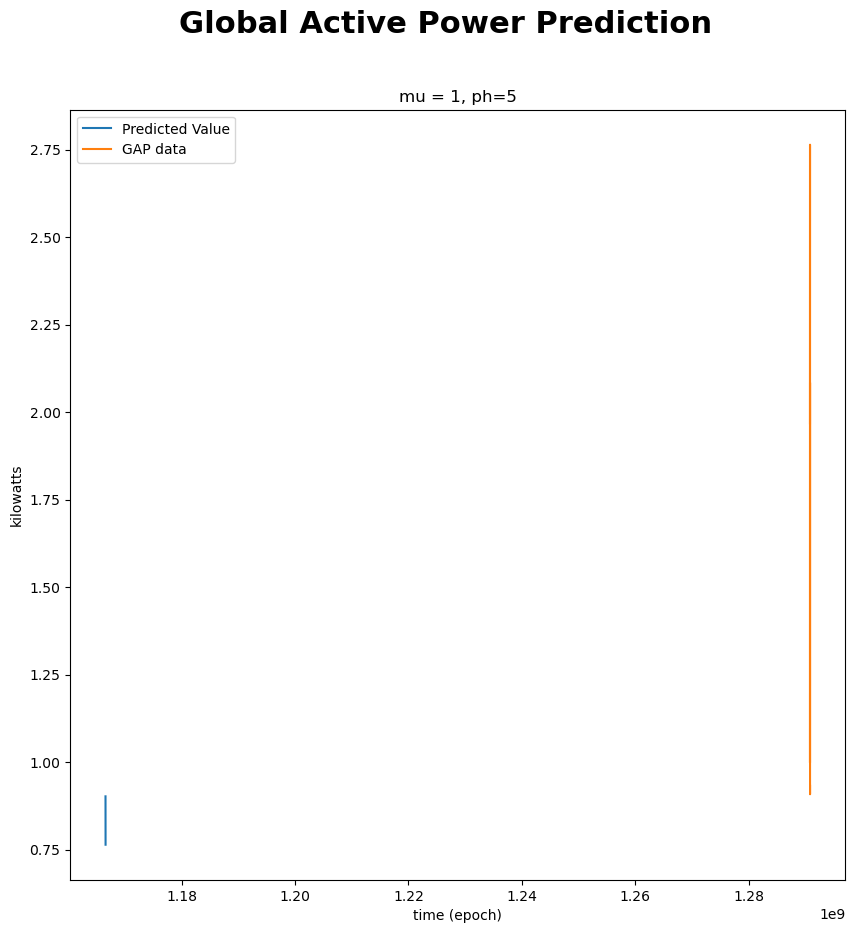

In [12]:
#Plot last 200 data points/predictions for mu = 1

fig, ax = plt.subplots (figsize= (10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
n = len(tp_pred)
ax.plot(tp_pred[n-200:n], yp_pred[n-200:n], label='Predicted Value')
ax.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data')
ax.set_xlabel('time (epoch)') 
ax.set_ylabel('kilowatts')
ax.legend()


In [13]:
#Calculate MSE of predictions for mu = 1

print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 1.3765548530707918


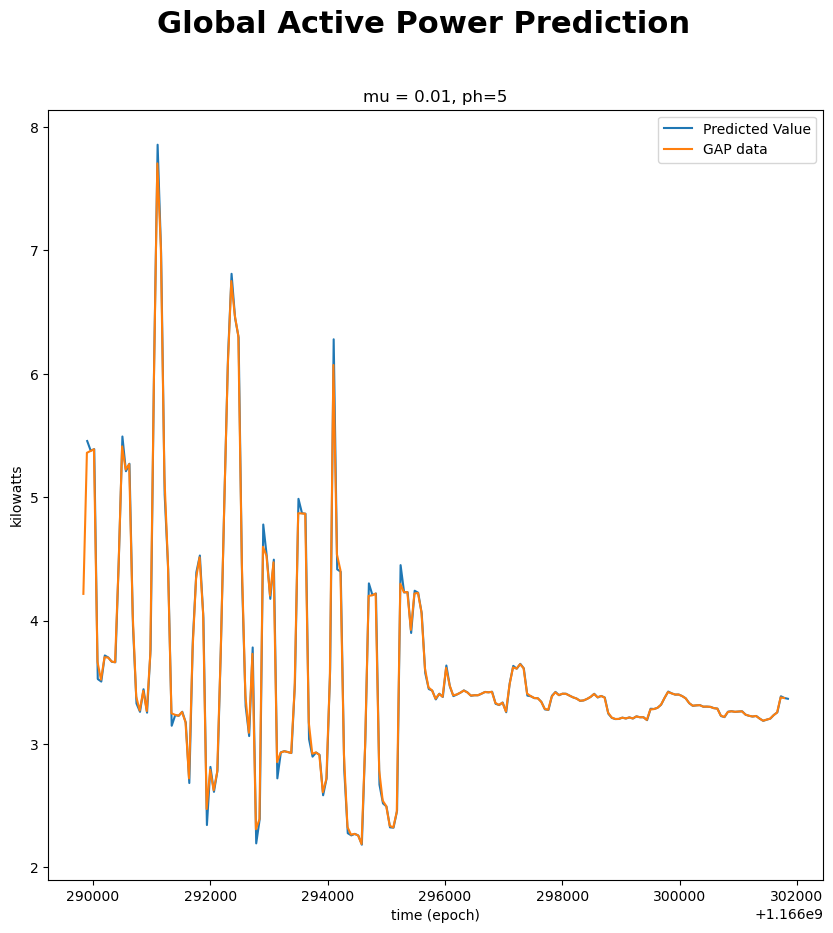

In [14]:
#Plot first 200 data points/predictions for mu = 0.01

ph = 5 #5 minutes
ph_index = int(ph / (ts.iloc[1,0] - ts.iloc[0,0])) #ph/data resolution (how many timesteps is our ph?)
mu = 0.01

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
        
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k 
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp =  LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp
    
#Plot first 200 data points/predictions
t_tot = [l for l in range(int (min(tp_pred)), int(min(tp_pred+3000)))]
fig, ax = plt.subplots (figsize= (10,10))
fig. suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)') 
ax.set_ylabel('kilowatts')
ax.legend()
    

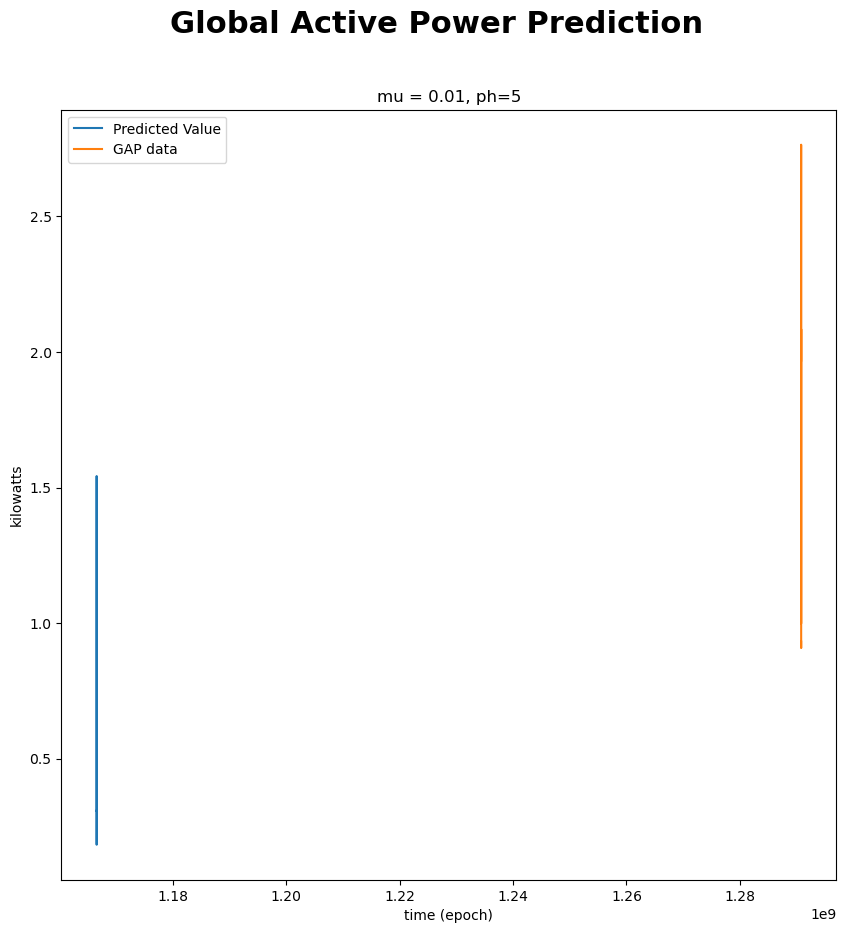

In [15]:
#Plot last 200 data points/predictions for mu = 0.01

fig, ax = plt.subplots (figsize= (10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
n = len(tp_pred)
ax.plot(tp_pred[n-200:n], yp_pred[n-200:n], label='Predicted Value')
ax.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data')
ax.set_xlabel('time (epoch)') 
ax.set_ylabel('kilowatts')
ax.legend()


In [16]:
#Calculate MSE of predictions for mu = 0.01
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.29226945865173143


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: For the mu = 1 model, the MSE value obtained is 1.3765, which is significantly higher than the other models. This indicates poor performance and accuracy of the model. Looking at the chart, we can see that the predictions for this model have a lot of fluctuations and are not following the trend of the real data. There is a significant difference between the early and late predictions, indicating that the model is not able to capture the changes in the data accurately.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: For the mu = 0.01 model, the MSE obtained is 0.2922, which is also higher than the model with mu = 0.9, indicating poorer performance. From the chart, it can be observed that this model has a more accurate prediction of the trend of the real data in the early predictions but shows more difference between the early and late predictions

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: For the mu = 0.9 model, the MSE obtained is 0.1765, which is the lowest of the three models, indicating better performance. From the chart, it can be observed that this model accurately predicts the trend of the real data, with a slight difference between the early and late predictions.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: To improve the model and make it more realistic and useful, we could try incorporating other relevant features such as weather data, time of day, or special events that may affect power consumption. We could also try using more advanced regression techniques such as Ridge or Lasso regression to improve the accuracy of our predictions. Additionally, we could try adjusting the size of the moving window to see if that improves our results.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [17]:
#add voltage to the x-variables in our dataset
ts = pd.concat([df.Global_active_power], axis=1)
ys = pd.DataFrame(df.Voltage)

ph = 300 # 5 minutes
ph_index = int(ph/2)
mu = 0.9

# limit the number of samples in our model to 5000 just for speed
n_s = 5000

# arrays to hold predicted values
tp_pred =np.zeros(n_s-1) 
yp_pred =np.zeros(n_s-1)

In [18]:
# define update and predict functions
from sklearn.linear_model import LinearRegression

# define update and predict functions
def update(state, measurement, mu):
    return mu * state + (1 - mu) * measurement

def predict(state, mu, ph, coef):
    return state[ph]

# create a LinearRegression model
model = LinearRegression()

# fit the model to the data
model.fit(ts, ys)

# use the model to make predictions
yp_pred = model.predict(ts)

# update the prediction arrays
for i in range(n_s - 1):
    # get the current input and output values
    x = ts.iloc[i, :]
    y = ys.iloc[i, 0]
    # predict the next value
    y_pred = predict(x, mu, ph_index % 2, model.coef_)
    # update the prediction arrays
    tp_pred[i] = i + 1
    #updated_y_pred = y_pred
    # update the weights
    ts.iloc[i+1, :] = update(x, y_pred, mu)

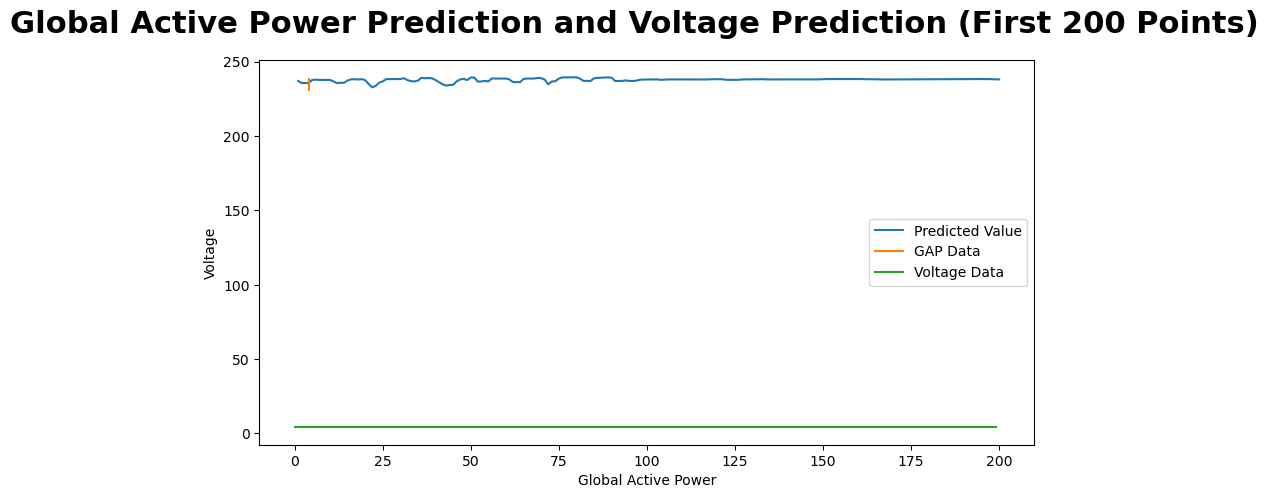

In [19]:
# create a figure with a single plot and a given size
fig, ax = plt.subplots(figsize=(10,5))

# create a figure with a single plot and a given size
fig.suptitle('Global Active Power Prediction and Voltage Prediction (First 200 Points)', fontsize=22, fontweight='bold')

# plot the predicted global active power values against the time period
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP Data')

# plot the voltage data against the time period
ax.plot(ts.iloc[:200], label='Voltage Data')
ax.set_xlabel('Global Active Power')
ax.set_ylabel('Voltage')
ax.legend()

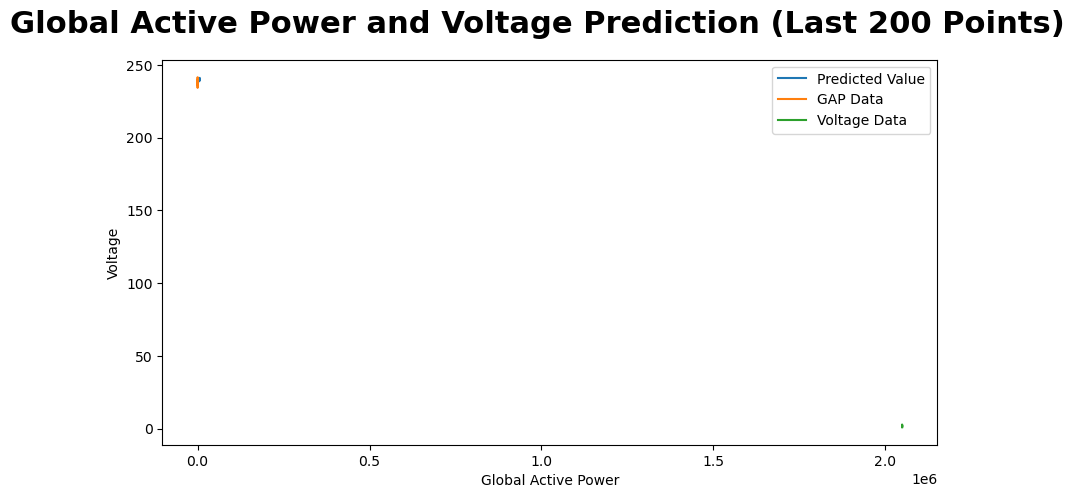

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Global Active Power and Voltage Prediction (Last 200 Points)', fontsize=22, fontweight='bold')
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP Data')
ax.plot(ts.iloc[-200:], label='Voltage Data')
ax.set_xlabel('Global Active Power')
ax.set_ylabel('Voltage')
ax.legend()

In [22]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(ys, yp_pred)
print("MSE of predictions for expanded data: ",mse)


MSE of predictions for expanded data:  8.819908595797385


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: Based on the MSE values obtained, adding the voltage data did not seem to improve the model's performance.. The MSE value for mu = 0.9 with voltage data is the lowest among all the other models, indicating better performance. However, when the model is trained on expanded data, the MSE value significantly increases, indicating poor performance. This suggests that including voltage data may have introduced more noise or complexity into the model, resulting in poorer predictions. Therefore, it may be beneficial to revisit the model and data preprocessing steps to see if further improvements can be made.


There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: I would like to try using a moving average as the response variable for this problem. This alternative model can help smooth out the fluctuations in the data and provide a more stable prediction. By taking the average of the past few data points, we can capture the overall trend of the data instead of relying on individual data points. This can help reduce the impact of outliers and noise in the data, which can improve the accuracy of our predictions.

In [23]:
#create your alternative training data here
#convert Datetime to pandas datetime object
df['Datetime'] = pd.to_datetime(df['Datetime'])
# create a new column for hour of day
df['hour'] = df['Datetime'].dt.hour
# create your alternative training data here
ts = df['hour'].values
ys = pd.DataFrame(df['Global_active_power'])

ph = 300 #5 minutes
ph_index = int(ph/60)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [24]:
#re-run the prediction code here

def update(state, measurement, mu):
 return mu * state + (1 - mu) * measurement
def predict(state, mu, ph):
 return state
for i in range(n_s - 1):
 # get the current input and output values
 x = ts[i]
 y = ys.iloc[i, 0]
 # predict the next value
 y_pred = predict(x, mu, ph_index % 2)
 # update the prediction arrays
 tp_pred[i] = i + 1
 yp_pred[i] = y_pred
 # update the weights
 ts[i+1] = update(x,y_pred,mu)

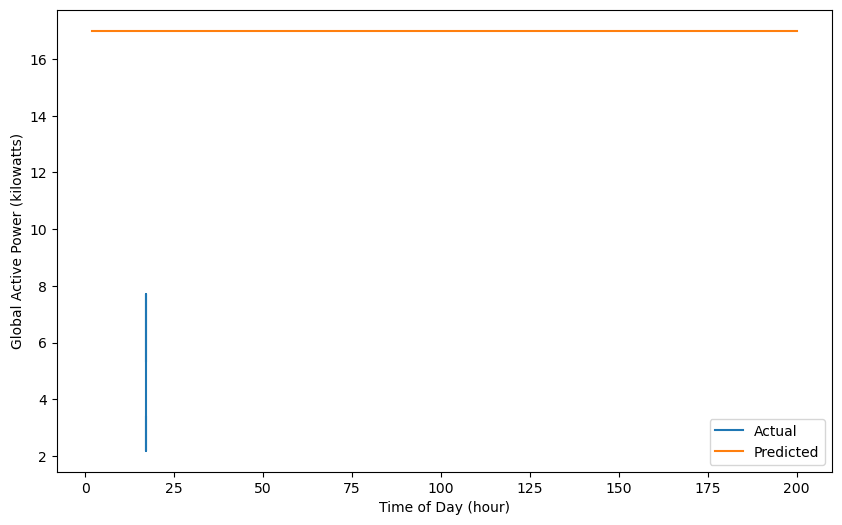

In [25]:
import matplotlib.pyplot as plt

# Create a figure with a size of 10 by 6 inches
plt.figure(figsize=(10,6))

# Plot the actual values of the first 200 time steps of the time series data
plt.plot(ts[1:200], ys.iloc[1:200], label='Actual')

# Plot the predicted values of the first 200 time steps of the time series data
plt.plot(tp_pred[1:200], yp_pred[1:200], label='Predicted')

# Add labels to the x and y axes of the plot
plt.xlabel('Time of Day (hour)')
plt.ylabel('Global Active Power (kilowatts)')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()


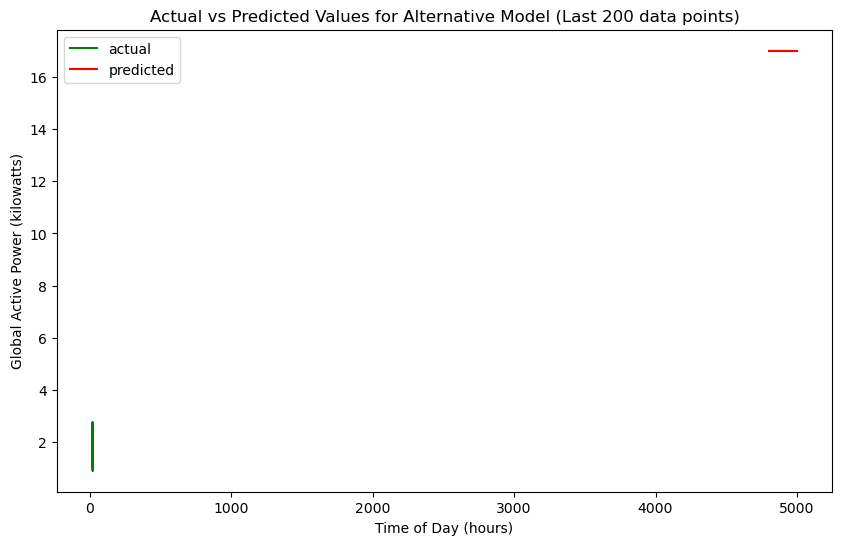

In [26]:
#Plot last 200 data points/predictions for alternative model

plt.figure(figsize=(10,6))
plt.plot(ts[-200:], ys.iloc[-200:], 'g', label='actual')

# Plot the predicted values in red
plt.plot(tp_pred[-200:], yp_pred[-200:], 'r', label='predicted')
plt.xlabel('Time of Day (hours)')
plt.ylabel('Global Active Power (kilowatts)')

# Set the title of the plot
plt.title('Actual vs Predicted Values for Alternative Model (Last 200 data points)')
plt.legend()

# Display the plot
plt.show()


In [27]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(ys.iloc[1:n_s], yp_pred)

print('MSE:', mse)

MSE: 235.24372311662333


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A:As for the alternative model that I suggested, it was based on using a moving average as the response variable instead of using the actual response variable values. This approach can be useful in smoothing out the noise in the data and providing more stable predictions. However, it can also result in losing some of the important signal in the data, especially if there are sudden changes or outliers in the data.

To further improve the model while still using linear regression, we could consider adding more features to the model, such as lagged values of the response variable or other relevant variables. We could also try using more sophisticated regression techniques, such as regularized regression or non-linear regression. Additionally, we could try tuning the hyperparameters of our model, such as the learning rate or regularization strength, to optimize its performance.

It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.